


# Análise exploratória de dados do Titanic

## Resumo
---
 
 [Introdução](#Introdução)

 [Conjunto de dados](#Conjunto-de-dados)
 
 [Ferramentas](#Ferramentas)

 [Questões-chave](#Questões-chave)

 [Considerações finais](#Considerações-finais)

 [Referências](#Referências)

 # Introdução
A tragédia no naufrágio do navio Titanic é muito retratada em diversas mídias. Nessas narrativas muitas histórias foram reveladas ao mostrar um pequeno conjunto de pessoas. A análise a seguir, na contramão, propõe-se a investigar um amplo conjunto de pessoas e aumentar o entendimento dos perfis das pessoas passageiras. 

# Ferramentas

Para análise foi utilizada a linguagem Python e suas bibliotecas: **pandas** para estrutura e manipulação de dados; **numpy** para operação com matrizes e vertores; **matplotlib**, **seaborn** e **squarify** para visualização de dados; **funções personalizadas** para manipulação dos dados; **formatação de tabela** personalizada para aprimorar a exibição dos dados.

In [1]:
# bibliotecas usadas para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

# bibliotecas complementares para análise
from data.data_modules import data_manipulation_functions as dm
from data.data_modules import data_plot_functions as pf
from data.data_modules import data_table_format as tab
from data.data_modules import data_styles_main as st

# Conjunto de dados

#### Fonte
Os dados oram fornecidos pela Udacity a partir de uma amostra do site Kaggle.  
Para mais detalhes, esse é o link para a fonte https://www.kaggle.com/c/titanic/data

#### Preparação dos dados
Para deixar os dados mais legíveis e consistentes de modo a preservar a informação, os dados passaram por um processo de limpeza. Durante a execução, algumas colunas foram avaliadas com relação à qualidade e pertinência de serem utilizadas na análise. Assim, dentre as 12 colunas foram delimitadas as seguintes 10 colunas:

- **survived** (informa se sobreviveu)
- **ticket_class** (classe da passagem)
- **name** (nome)
- **gender** (sexo)
- **age** (idade)
- **siblings_or_spouses** (quantidade de irmãs(ãos) ou  cônjuges a bordo)
- **parents_or_children** (quantidade de pais ou filhas(os) a bordo)
- **ticket_number** (número do bilhete)
- **fare** (tarifa paga) 
- **embarkation_city** (cidade de embarque)

Dentre as colunas, a que contém os dados referentes a idade possuia cerca de 80% dos dados completos. Para permitir cruzamentos entre outras variáveis, os cerca de 20% de dados foram preenchidos de modo randômico de modo a preservar a proporção de diferençãs de idade dos dados completos.

O passo a passo realizado pode ser verificado em [/data/data_wrangling.ipynb](./data/data_wrangling.ipynb)

In [2]:
# carregamento dos dados
data_titanic = pd.read_csv('./data/data_titanic_clean')

# exibição das 3 primeiras linhas do conjunto de dados
tab.format_table(data_titanic.head(10))

,name,age,gender,ticket_class,fare,ticket_number,embarkation_city,siblings_or_spouses,parents_or_children,survived
0,"Braund, Mr. Owen Harris",22,male,third,7.25,A/5 21171,Southampton,1,0,no
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38,female,first,71.2833,PC 17599,Cherbourg,1,0,yes
2,"Heikkinen, Miss. Laina",26,female,third,7.925,STON/O2. 3101282,Southampton,0,0,yes
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,female,first,53.1,113803,Southampton,1,0,yes
4,"Allen, Mr. William Henry",35,male,third,8.05,373450,Southampton,0,0,no
5,"Moran, Mr. James",20.9,male,third,8.4583,330877,Queestown,0,0,no
6,"McCarthy, Mr. Timothy J",54,male,first,51.8625,17463,Southampton,0,0,no
7,"Palsson, Master. Gosta Leonard",2,male,third,21.075,349909,Southampton,3,1,no
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27,female,third,11.1333,347742,Southampton,0,2,yes
9,"Nasser, Mrs. Nicholas (Adele Achem)",14,female,second,30.0708,237736,Cherbourg,1,0,yes


#### Exploração dos dados

Além do conjunto de dados a partir da preparação, no decorrer da análise, novas combinações entre os dados foram realizadas conforme podem ser conferidas abaixo: 

In [3]:
# mediana que divide os valores pagoso pela primeira classe
first_class_median_fare = data_titanic.query('ticket_class == "first"')['fare'].median()

# destino das pessoas
survivors = data_titanic.query('survived == "yes"')
victims = data_titanic.query('survived == "no"')

# viajantes sós vs familiares
single = data_titanic.query('siblings_or_spouses == 0 and parents_or_children == 0')
with_family = data_titanic.query('siblings_or_spouses != 0 and parents_or_children != 0')
data_titanic['companion'] = pd.DataFrame({'companion':['single']*len(single.index)}, index=single.index)
data_titanic['companion'].fillna('with_family', inplace=True)
data_titanic['survived companion'] = [f'{"survivor" if item == "yes" else "victim"} {data_titanic["companion"][index]}' 
                                        for index, item in data_titanic['survived'].iteritems()]

# embarque
embarkation_cities = data_titanic.query('embarkation_city != "not_provided"')

# idade
data_titanic['maturity'] = data_titanic['age'].apply(lambda age: 'adult' if age < 18 else 'child')
adults = data_titanic.query('age > 18')
kids = data_titanic.query('age <= 18')

# cruzamentos entre conjunto de dados
companion_x_destiny_percentage_all = pd.crosstab(data_titanic['companion'], data_titanic['survived'],\
                                                 normalize='all')
companion_x_destiny_percentage_row = pd.crosstab(data_titanic['companion'], data_titanic['survived'],\
                                                 normalize='index')
companion_x_destiny_amount = pd.crosstab(data_titanic['survived'], data_titanic['companion'], margins=True)
companion_amount = companion_x_destiny_amount[-1:]
class_cities_mean_fare = pd.crosstab(index=data_titanic['ticket_class'], margins='all',\
                                     columns=data_titanic['embarkation_city'],\
                                     values=data_titanic['fare'], aggfunc='mean')
class_cities_mean_fare = class_cities_mean_fare[['Southampton', 'Cherbourg', 'Queestown']]
max_city_mean_ticket = max(class_cities_mean_fare.describe().max())

class_cities_mean_survivors = pd.crosstab(index=survivors['ticket_class'], margins='all',\
                                          columns=embarkation_cities['embarkation_city'],\
                                          values=survivors['survived'], aggfunc='count')
class_cities_mean_survivors = class_cities_mean_survivors[['Southampton', 'Cherbourg', 'Queestown']]
class_cities_mean_survivors_max = max(class_cities_mean_survivors.loc['All':].describe().max())

class_cities_mean_victims = pd.crosstab(index=victims['ticket_class'], margins='all',
                                        columns=embarkation_cities['embarkation_city'],\
                                        values=victims['survived'], aggfunc='count')
class_cities_mean_victims = class_cities_mean_victims[['Southampton', 'Cherbourg', 'Queestown']]
class_cities_mean_victims_max = max(class_cities_mean_victims.loc['All':].describe().max())

class_cities_mean_survivors_victims_max = max(class_cities_mean_survivors_max, class_cities_mean_victims_max)

companion_amount_no_totals = companion_x_destiny_amount[:-1][['single','with_family']]

destiny_melt_survived_label = pd.crosstab(index=data_titanic['survived'], columns=data_titanic['survived companion'], 
            values=data_titanic['survived'], aggfunc='count', dropna=True).transpose().fillna(0)

destiny_melt_survived_melted = pd.melt(destiny_melt_survived_label\
                                       .transpose()).groupby('survived companion').sum()

#### Descrição da amostra
A amostra contém **891** dados que representam cerca de **20%** da quantidade total de **2224** referentes às pessoas presentes no navio. Por possuir apenas informações sobre a classe do tipo de passagem comprada, podemos considerar que essa **amostra é delimitada aos passageiros** do navio. Isso deixa de fora, assim, informações sobre a tripulação.

# Questões-chave
A investigação feita buscou focar em temas relacionados a idade, gênero e econômico a partir da amostra de dados do Titanic. Para chegar às questões da análise, primeiramente foram elaboradas algumas questões iniciais (1) antes da limpeza dos dados e uma outra questão(2) depois.
Assim, como resultado, as seguintes questões-chave foram elencadas:

#### Questões
1. Pessoas com maior poder aquisitivo também foram as que mais sobreviveram à tragédia?
- Viajar sem seus familiares aumentou as chances de escapar do naufrágio?

### 1. Pessoas com maior poder aquisitivo também foram as que mais sobreviveram à tragédia?

Há duas variáveis no conjunto de dados que indicam poder aquisitivo: **ticket_class**(classe da passagem) e  **fare** (tarifa paga). Ambas ficam restritas ao contexto da viagem portanto outros bens como imóveis ou heranças não foram informados. Para efeito da análise, vamos considerar, principalmente, pessoas com alto poder aquisitivo àquelas da primeira classe e com alto valor de tarifa pago e pessoas com baixo poder aquisitivo o contrário.

#### Classes
A classe das passagens é dividida em 3 tipos (primeira, segunda e terceira) que, a princípio, sugerem estar categorizados da mais cara para mais barata. Por si só já seria um critério que aponta, no geral, para o poder aquisitivo da pessoa. No entanto precisamos considerar que há outros motivos pelos quais uma pessoa pode obter descontos sobre a passagem (até mesmo não pagamento).

In [4]:
# quantidade de pessoas que não pagaram por classe de passagem
pd.crosstab(data_titanic.query('fare == 0')['fare'], data_titanic['ticket_class']).to_dict()

{'first': {0.0: 5}, 'second': {0.0: 6}, 'third': {0.0: 4}}

A partir dessa sugestão de relação inicial, há de fato uma correspondência entre tipo de classe e valor pago na tarifa de fato nessa amostra?

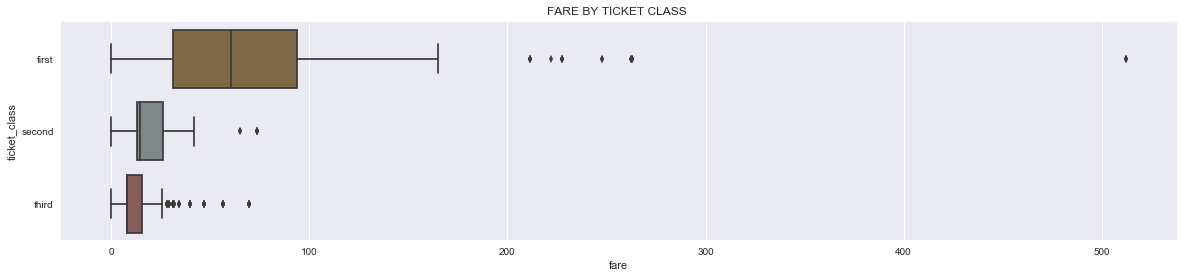

In [5]:
figure, ax = plt.subplots(1,1, figsize=(20,4))
# ----------------------------------------------------------------------------------------------------
fare_ticket_class = sns.boxplot(y='ticket_class', x='fare', data=data_titanic,\
            palette=st.palette_classes, order=['first', 'second', 'third'])
pf.set_title(fare_ticket_class, 'Fare by ticket class ')
# ----------------------------------------------------------------------------------------------------
figure.show()

Por meio da gráfico podemos confirmar que sim com exceção de alguns outliers (valores com anomalia em relação ao todo) os valores da tarifa correspondem no geral, ao tipo de classe de passagem: da primeira com tarifa maior até a terceira com tarifa menor.

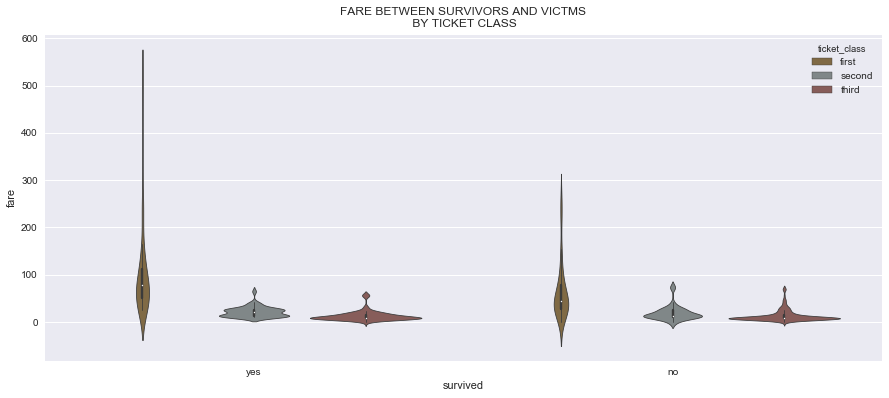

In [6]:
figure, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(15,6))
# ----------------------------------------------------------------------------------------------------
fare_ticket_class_destiny = sns.violinplot(x='survived', y='fare', order=['yes','no'], data=data_titanic,\
                                   hue_order=['first','second','third'], hue='ticket_class',\
                                   palette=st.palette_classes, linewidth=0.8 )
pf.set_title(fare_ticket_class_destiny, 'Fare between survivors and victms\n by ticket class')
# ----------------------------------------------------------------------------------------------------
figure.show()

Acima comparamos as pessoas que sobreviveram e morreram com as classes delas. Podemos destacar, por meio das distribuições, que tivemos mais casos de pessoas que sobreviveram que pagaram acima da média da primera classe. Segunda e terceira classes não apresentaram diferenças de distribuição muito contrastantes.

#### Tarifas
A tarifa paga informada no conjunto de dados não deixa claro sobre o que exatamento foi pago: passagem? taxa de embarque? serviços extras? Vamos levar em conta, para análise, que seja pelo menos o valor da passagem.

In [7]:
# mediana
total_above_median = data_titanic.query(f'fare >= {first_class_median_fare}')['fare'].count()
survivors_above_median = survivors.query(f'fare >= {first_class_median_fare}')['fare'].count()
victims_above_median = victims.query('fare >= 62.3')['fare'].count()

survivors_above_medium_percentage = dm.get_percent_of(survivors_above_median, total_above_median)
victims_above_medium_percentage = dm.get_percent_of(victims_above_median, total_above_median)

print(f'survivors_above_medium_percentage: {survivors_above_medium_percentage}%',
      f'\nvictims_above_medium_percentage: {victims_above_medium_percentage}%')

survivors_above_medium_percentage: 67.21311475409836% 
victims_above_medium_percentage: 30.327868852459016%


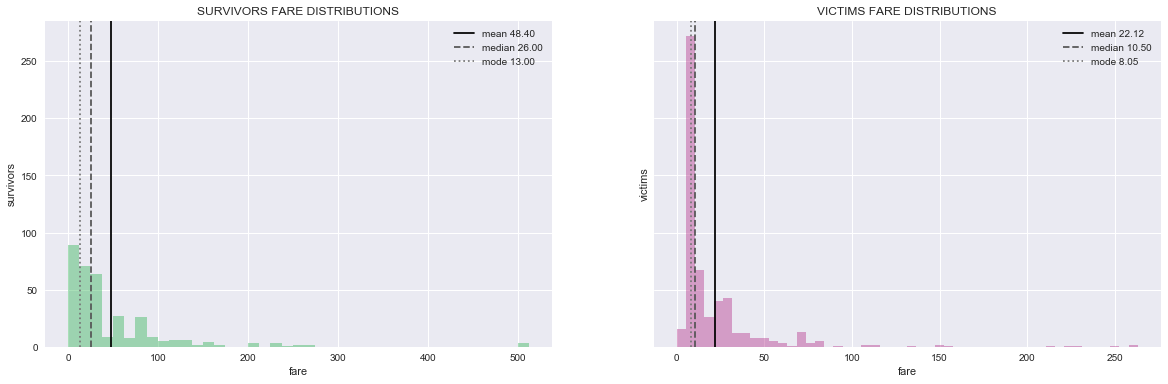

In [8]:
figure, ax = plt.subplots(1,2, sharex='col', sharey='row', figsize=(20, 6))
# ----------------------------------------------------------------------------------------------------
fare_survivors = pf.plot_distribution_with_means(survivors['fare'], color=st.color_survivors, ax=ax[0],\
                                                 title='Survivors fare distributions').set_ylabel('survivors')

fare_victims = pf.plot_distribution_with_means(victims['fare'], color=st.color_victims, ax=ax[1],\
                                               title='Victims fare distributions').set_ylabel('victims')
# ----------------------------------------------------------------------------------------------------
figure.show()

In [9]:
# dir(fare_victims)

Por meio da distribuição dos valores das passagens acima, podemos observar a concentração dos valores pagos com relação aos sobreviventes e às vítimas. Disso, o que se destaca é a alta concentração de quantidade de vítimas que pagaram um valor baixo de passagem.  

Ainda sobre o gráfico, vemos que a média geral do valor pago para viajar pelos sobreviventes é mais que o dobro do das vítimas: 48,40 média paga pelos sobreviventes vs 22,12 média das vítimas. Além disso, 

os acima da média dos mais primeira classe e que ainda assim pagaram mais da média das pessoas sobreviventes foram daquelas que pagaram mais da metade dos valores  (62,3).

Outro ponto importante é o valor médio das tarifas considerando a cidade de embarque. A rota seria sair da cidade Southampton, passar por Cherbourg, em seguida por Queestown e, por último, atravessar o oceano Atlântico até chegar em New York. Diferente do tipo de cobrança em que a passagem é mais cara conforme a distância percorrida entre embarque ao destino, vemos pelo heatmap a seguir que, quem embarcou na segunda cidade Cherbourg, na média geral pagou mais caro.

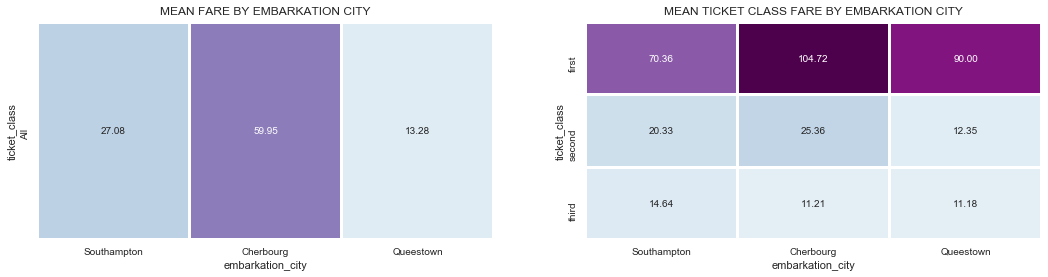

In [10]:
figure, ax = plt.subplots(1,2, figsize=(18, 4))
# ----------------------------------------------------------------------------------------------------
cities_mean = sns.heatmap(class_cities_mean_fare.loc['All':], annot=True, fmt='.2f', cmap='BuPu',\
                          ax=ax[0], vmin=0, vmax=max_city_mean_ticket, cbar=False, linewidths=2)
pf.set_title(cities_mean, 'Mean fare by embarkation city')

cities_mean_cities = sns.heatmap(class_cities_mean_fare.drop('All'), annot=True, fmt='.2f', cmap='BuPu',\
                                 ax=ax[1], vmin=0, vmax=max_city_mean_ticket, cbar=False, linewidths=2)
pf.set_title(cities_mean_cities, 'Mean ticket class fare by embarkation city')
# ----------------------------------------------------------------------------------------------------
figure.show()

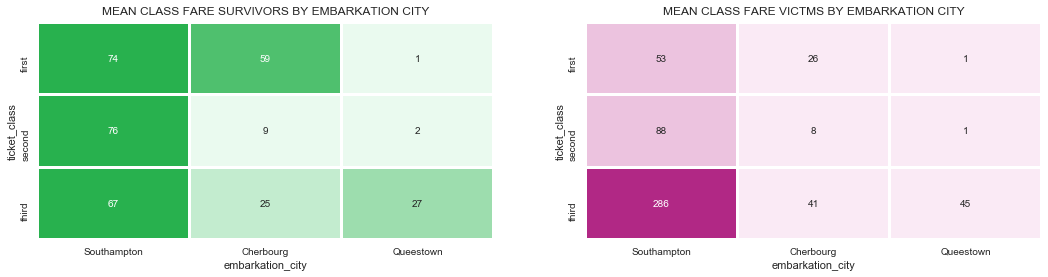

In [11]:
figure, ax = plt.subplots(1,2, figsize=(18,4))
# ----------------------------------------------------------------------------------------------------
class_cities_mean_heatmap_survivors = sns.heatmap(class_cities_mean_survivors.drop(index='All'),\
                                                  annot=True, ax=ax[0], fmt='#', cbar=False,\
                                                  vmin=0,\
                                                  linewidths=2, cmap=sns.light_palette(st.color_survivors))
pf.set_title(class_cities_mean_heatmap_survivors, 'Mean class fare survivors by embarkation city')

class_cities_mean_heatmap_victims = sns.heatmap(class_cities_mean_victims.drop(index='All'), annot=True, ax=ax[1],\
                                                fmt='#', vmin=0, \
                                                cbar=False, linewidths=2, cmap=sns.light_palette(st.color_victims))
pf.set_title(class_cities_mean_heatmap_victims, 'Mean class fare victms by embarkation city')
# ----------------------------------------------------------------------------------------------------
figure.show()

A respeito da quantidade de sobreviventes por cidade de embarque, a prevalência, no entanto, se deu na cidade de saída Southampton. Esta também se destaca por ter tido uma quantidade de sobreviventes de várias classes mais equilibrado com cerca de **72** sobreviventes por classe.

#### Fechamento
De acordo com a amostra, confirmamos primeiramente que existe uma relação direta entre classe e o valor pago. A seguir, essas duas variáveis foram usadas como critérios para informar se alguém tem um alto ou baixo poder aquisitivo.  
Empbora não seja possível afirmar o porquê, pessoas passageiras com alto poder aquisitivo foram sim as que mais sobreviveram. Isso é reforçado pelo grande quantidade de pessoas da primeira classe sobrevivente com destaque para as pessoas com maior pagamento de tarifa. Em contraste, a maior concentração de vítimas é de pessoas da terceira classe. 

### 2. Viajar sem familiares aumentou as chances de escapar do naufrágio?

Para saber quais pessoas estavam a bordo sem familiares vamos levar em conta duas variáveis da amostra: **siblings_or_spouses** (quantidade de irmãs(ãos) ou  cônjuges a bordo) e **parents_or_children** (quantidade de pais ou filhas(os) a bordo). Vale mencionar que, por falta de dados das cabines não podemos isolar pessoas que por ventura viajaram com amigos que podem ser considerados mais próximos do que familiares em alguns casos.

Para separar do conjunto isolamos as pessoas que estão com 0 nas duas variáveis mencionadas. Os agrumentos dos dados necessários para o que se segue pode ser conferido em [Exploração dos dados](#Exploração-dos-dados).

'single percentage 60.27'

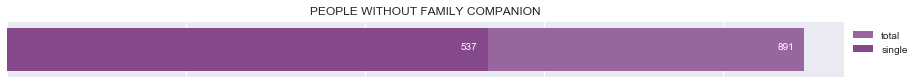

In [12]:
figure, ax = plt.subplots(1,1, figsize=(15,1))
plot_companion_total = sns.barplot(x='All', data=companion_amount, label='total', color=st.color_family, ci=None)
plot_companion_single = sns.barplot(x='single', data=companion_amount, label='single', color=st.color_single, ci=None)
ax.legend(ncol=1, loc=0, bbox_to_anchor=(1, 1))
pf.set_title(plot_companion_total, 'People without family companion')

for index, item in companion_amount[['single','All']].iteritems():
    ax.text(item.values[0] - 30, 0, item.values[0], color='#ffffff')

ax.label_outer()
ax.set_xlabel('')
ax.set_xticklabels('')

f'single percentage {round(dm.get_percent_of(companion_amount["single"], companion_amount["All"])["All"], 2)}'


Por meio do gráfico de barras acima vemos que a grande maioria viajava sem familiares com representação de cerca de 60% do total.

Ao incluir na comparação os dados da coluna sobre sobrevivência, vemos, outra situação. O gráfico abaixo mostra uma representação proporcional entre a quantidade de pessoas sem família que sobreviveram (*survivor single*), vítimas (*victim single*) sem familiares, comparadas àquelas com familiares sobreviventes (*survivor with family*) e vítimas (*victim with family*). Visualmente podemos constatar a grande maioria das vítimas foi justamente pessoas que viajaram sem a companhia de familires.

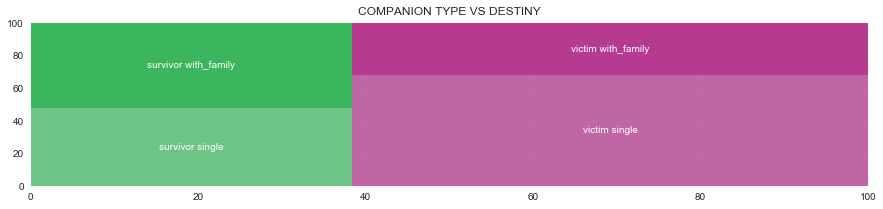

In [13]:
figure, ax = plt.subplots(figsize=(15,3))
# ----------------------------------------------------------------------------------------------------
plot_companion_area_map = squarify.plot(sizes=destiny_melt_survived_melted['value'],\
                                        label=destiny_melt_survived_melted.index, alpha=0.9,\
                                        color=[st.color_survivors_light,\
                                               st.color_survivors,\
                                               st.color_victims_light,\
                                               st.color_victims])
pf.apply_all_texts_color(ax, '#ffffff')
pf.set_title(plot_companion_area_map, 'Companion type vs Destiny')
# ----------------------------------------------------------------------------------------------------
plt.show()

Ao fazermos uma comparação de proporpocionalidade àqueles que sobreviveram sem comparar cada conjunto com o todo vemos mais diferenças. Enquanto aqueles que viajaram com familiares pouco mais da metade sobreviveu (51%), por outro lado, daqueles que viajaram sem familiares apenas 30% sobreviveu.

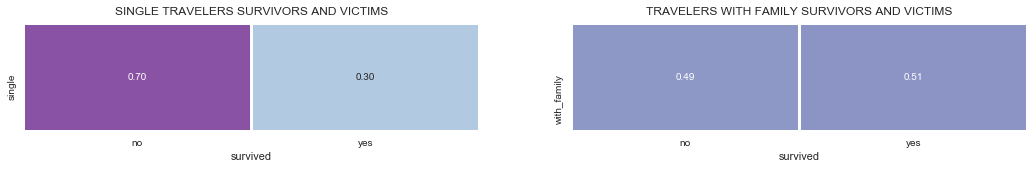

In [14]:
figure, ax = plt.subplots(1,2, figsize=(18, 2))
# ----------------------------------------------------------------------------------------------------
single_destiny = sns.heatmap(companion_x_destiny_percentage_row.iloc[:-1], annot=True, fmt='.2f', cmap='BuPu',\
                          ax=ax[0], vmin=0, vmax=1, cbar=False, linewidths=2)
pf.set_title(single_destiny, 'Single travelers survivors and victims')
single_destiny.set_ylabel('')

single_destiny = sns.heatmap(companion_x_destiny_percentage_row.iloc[1:], annot=True, fmt='.2f', cmap='BuPu',\
                          ax=ax[1], vmin=0, vmax=1, cbar=False, linewidths=2)
pf.set_title(single_destiny, 'Travelers with family survivors and victims')
single_destiny.set_ylabel('')

cities_mean_cities.set_xlabel('') and cities_mean_cities.set_ylabel('')
# ----------------------------------------------------------------------------------------------------
figure.show()

Muitos motivos podem ter levado uma pessoas ter sobrevivido. Por meio dos dados disponíveis não é possível afirmar que viajar sem familires permitiu maiores ou menores chances de sobrevivência. Podemos, constatar que, no caso do Titanic, independente dos motivos, mais pessoas viajando com familiares escaparam da tragédia.

# Considerações finais

A análise, embora restrita mais às pessoas passageiras permitiu explorar duas questões-chave comparando diversos aspectos dos dados. Conseguimos entender mais, de modo geral, a respeito do perfis daqueles que possivelmente detinham mais poder aquisitivo e das pessoas que viajaram sem algum familiar.

Até por restrição da amostragem, essa análise, não traz um retrato fiel sobre aspectos da tragédia do Titanic mas visa contribuir para gerar mais hipóteses a respeito para outros estudos considerando um escopo maior de dados incluindo também dados da tripulação.

### Referências

##### Fonte
- [Kaggle - Titanic](https://www.kaggle.com/c/titanic/data)

##### Conteúdos sobre Titanic:
- [Em naufrágios, crianças e mulheres têm mesmo prioridade?](https://super.abril.com.br/mundo-estranho/em-naufragios-criancas-e-mulheres-tem-mesmo-prioridade/)
- [Em naufrágios e outros desastres, mulheres e crianças só conseguem sair por último](http://revistagalileu.globo.com/Revista/Common/0,,EMI302308-17770,00-EM+NAUFRAGIOS+E+OUTROS+DESASTRES+MULHERES+E+CRIANCAS+SO+CONSEGUEM+SAIR+POR+.html)
- [Nerdologia - Titanic](https://www.youtube.com/watch?v=GlEV_2qbvx8)


##### Análises de dados
- [Lautert, Larissa. Análise exploratória da fila - hacking-health-sc-2017](https://github.com/llautert/hacking-health-sc-2017/blob/master/An%C3%A1lise%20explorat%C3%B3ria%20da%20fila.ipynb)
- [Reis, Filipe - T2 - Análise Exploratória de Dados - Filipe Reis - RA091202](https://github.com/fireis/ia369w_exp_data_ana/blob/master/T2%20-%20Saude%20-%20Filipe%20Reis%20-%20RA091202.ipynb)
- [Siqueira, Fernando - Análise de notas de alunos](https://github.com/fernandolkf/dotdigitalwith_family/blob/master/dotdigitalwith_family.ipynb)


##### Técnicos
- [Handling missing data](https://www.oreilly.com/learning/handling-missing-data)
- [Mean Median Mode lines showing only in last graph in seaborn](https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn/51417635)

- [A collection of various notebook extensions for Jupyter](https://github.com/ipython-contrib/jupyter_contrib_nbextensions)
- [Basic Treemap with python](https://python-graph-gallery.com/200-basic-treemap-with-python/)
- [Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp)
- [Percent stacked barplot](https://python-graph-gallery.com/13-percent-stacked-barplot/)
- [5 reasons you should use a violin graph](https://medium.com/@bioturing/5-reasons-you-should-use-a-violin-graph-31a9cdf2d0c6)
- [Reshaping Pandas Data With Melt](https://www.codementor.io/abhishake/reshaping-pandas-data-with-melt-lazg3j4te)

#### Complementares
- [The convention on the Rights of the child](https://www.unicef.org/crc/files/Guiding_Principles.pdf)